In [16]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

# For downloading the image.
import matplotlib.pyplot as plt

# For drawing onto the image.
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.9.1
The following GPU devices are available: 


In [7]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [14]:
def open_image(path):
    image = Image.open("image_path.jpg")
    image.show()

In [15]:
def resize_image(img, new_width=320, new_height=320, display=False):
    pil_image = ImageOps.fit(img, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

In [10]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                    fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [11]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])
        np.copyto(image, np.array(image_pil))
    return image

In [12]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [69]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key:value.numpy() for key,value in result.items()}

    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

In [73]:
def print_results(path, result):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    print("Found %d objects." % len(result["detection_scores"]))

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)

In [17]:
test_data = pd.read_csv('/Users/corneliusheidrich/code/mchouvel/counting_cards/raw_data/test/_annotations.csv')

In [41]:
test_data.head(1)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,191004275_jpg.rf.009a7ed573349e95089d06ff082c9...,416,416,4D,127,137,148,161


In [88]:
detection_boxes = np.array([[test_data.loc[0,'ymin'], test_data.loc[0,'xmin'], test_data.loc[0,'ymax'], test_data.loc[0,'xmax']]])
detection_boxes

array([[137, 127, 161, 148]])

In [98]:
detection_class_entities = np.array([test_data.loc[0,'class']])
detection_class_entities

array(['4D'], dtype='<U2')

In [99]:
detection_scores = np.array([0.9])

In [100]:
results = {'detection_boxes': detection_boxes, 'detection_class_entities': detection_class_entities, 'detection_scores': detection_scores}

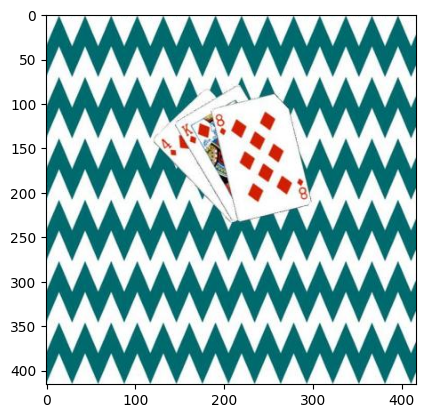

In [101]:
data_path = '/Users/corneliusheidrich/code/mchouvel/counting_cards/raw_data/test/'
img_path = data_path + test_data.loc[0,'filename']
img = Image.open(img_path)
plt.imshow(img)

In [102]:
print_results(img_path, results)

Found 1 objects.
Font not found, using default font.


AttributeError: 'numpy.str_' object has no attribute 'decode'